In [1]:

import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable

from utility_functions.utils import * #read_data, read_press, getnearpos, folder_files, headspace
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
rc['font.family'] = 'sans-serif'
rc['font.sans-serif'] = ['Verdana']


In [2]:
def plot_cycle(disch, chrg, press, channel, style=None, n=None, leg=''):
    color= 'xkcd:ocean blue'
    if n==None:
        n=2
#     color='#045a8d'
#     color='xkcd:cerulean'
    #find currents for charge and discharge and //normalize by area
    disc_i= np.mean(disch['I/mA']) #/(np.pi*0.6**2)
    chrg_i= np.mean(chrg['I/mA']) #/(np.pi*0.6**2)
    print('discharge current (mA): ' +str(disc_i))
    #find the final capacity reached on discharge in mAh
    cap=disch['Capacity/mA.h'].iloc[-1]
    if style ==None:
        style = 'solid'
        
    x1=disch['Capacity/mA.h'] #/(np.pi*0.6**2)
    y1=disch['Ewe/V']
    
    x2=(cap-chrg['Capacity/mA.h']) #/(np.pi*0.6**2)
    y2=chrg['Ewe/V']
    
    fig, ax= plt.subplots( figsize=(7,5))
    ax2 = ax.twinx()
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    
    ax.plot(x1, y1, c=color, linestyle=style, label=leg, linewidth=2)
    if (str(disch) != str(chrg)):
        ax.plot(x2, y2, c=color, linestyle=style, label='', linewidth=2)
    
    st1=disch['time/s'].iloc[0]
    end1=disch['time/s'].iloc[-1]
    
    st2=chrg['time/s'].iloc[0]
    end2=chrg['time/s'].iloc[-1]
    
    #determine start and end indices in pressure df for discharge and charge
    st_p1 = getnearpos(press['time/s'],st1)
    end_p1 = getnearpos(press['time/s'],end1)
    
    st_p2 = getnearpos(press['time/s'],st2)
    end_p2 = getnearpos(press['time/s'],end2)
    
    temp = press['temperature/C']+273
    umoles = press['pressure/torr']/760*headspace(channel)/temp/0.082057
    umoles = umoles-umoles.iloc[st_p1]
    elec_oxy= x1.iloc[-1]*3.6/96485/umoles[end_p1]
    
    leak_time = np.array(press['time/s'].iloc[5:st_p1-2])
    leak_umol = np.array(umoles.iloc[5:st_p1-2])
    leak_umol = leak_umol- leak_umol[0]
    m, b = np.polyfit(leak_time,leak_umol, 1)
    #plt.figure()
    #plt.plot(leak_time/60, (m*leak_time + b), 'k--', label = 'line of best fit')
    #plt.plot(press['time/s']/60, umoles)
    m = round(m, 5)
    disch_time_min = round((disch['time/s'].iloc[-1]- disch['time/s'].iloc[0])/60, 5)
    
    print( 'pressure change rate is: ' + str(m*60) + ' umoles/min so over the duration of discharge ('\
          + str(disch_time_min) + ' min), ' + str( m*60*disch_time_min) + ' umoles of gas were consumed through side process' )
    
    x=[0,cap] #/(np.pi*0.6**2)]
    y=[0,-cap*3.6/n/96485*10**6]
    
    disch_cap=(press['time/s']-press['time/s'].iloc[st_p1])*-disc_i/3600
    char_cap=cap -(press['time/s']-press['time/s'].iloc[st_p2])*chrg_i/3600 #divide cap by/(np.pi*.6**2)

    gap= umoles[end_p1]-umoles[st_p2]
    print((disch_cap.iloc[-1]*3.6/96485/(umoles[end_p1]*10**(-6))))
    line1, = ax2.plot(x, y, 'k-' , label= str(n)+' e$^-$/O$_2$',linewidth= 2, linestyle = '--')
    ax2.plot(disch_cap[st_p1:end_p1+1], (umoles)[st_p1:end_p1+1], 'o', color='#001933', label='discharge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6))) # color '#9E0003' '#ec7014'
    if (str(disch) != str(chrg)):
        ax2.plot(char_cap[st_p2:end_p2+1], (umoles)[st_p2:end_p2+1]+gap, 'o', mfc='white', color='#001933', label='charge', linewidth=3, markevery=(0.0,0.02))# (0,(6,6)))
    
    print("o2 consumed: "+ str(umoles[st_p1]-(umoles[end_p1+1] )))
    print("o2 evolved: "+ str(umoles[end_p2]-(umoles[st_p2+1] )))
    print((umoles[end_p2]-(umoles[st_p2+1]))/(umoles[st_p1]-(umoles[end_p1+1])))

    epermol_c = cap * 3.6 / 96485 *10**6 / (umoles[end_p2-1]-(umoles[st_p2+1]))
    epermol_d = cap * 3.6 / 96485 *10**6 / (umoles[st_p1]-(umoles[end_p1+1]))
    
    #slope_c, int_c = np.polyfit(char_cap[st_p2:end_p2], umoles[st_p2:end_p2], 1)
    #epermol_c = 1/(slope_c/3.6*96485/10**6)
    #slope_dis, int_dis = np.polyfit(disch_cap[st_p1:end_p1], umoles[st_p1:end_p1], 1)
    #epermol_d = -1/(slope_dis/3.6*96485/10**6)
    
    ax2.legend(fontsize=14)
    ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', color=color, fontsize=20)
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax2.set_ylabel('n$_{gas}$ ($\mu$mol)', fontsize=20)
    plt.tight_layout()
    ax.set_ylim([0,3.5])
    
    
    
    
    print('e per mol on discharge = ' + str(epermol_d))
    #print('e per mol on charge = ' + str(epermol_c))
    
    return 

discharge current (mA): -0.09994220040192928
pressure change rate is: 0.0018 umoles/min so over the duration of discharge (300.0 min), 0.54 umoles of gas were consumed through side process
-7.10044626657131
o2 consumed: 5.314605696731846
o2 evolved: -5.312577746640841
-0.9996184194638839
e per mol on discharge = 3.5082158329349045
discharge current (mA): -0.09993537589220919
pressure change rate is: -0.003 umoles/min so over the duration of discharge (300.0 min), -0.9 umoles of gas were consumed through side process
-14.113263236721814
o2 consumed: 5.85523678853896
o2 evolved: 5.383084087648271
0.9193623216374647
e per mol on discharge = 3.18413925975224
discharge current (mA): -0.09993783494203684
pressure change rate is: 0.0006000000000000001 umoles/min so over the duration of discharge (600.0 min), 0.36000000000000004 umoles of gas were consumed through side process
-4.739611293551002
o2 consumed: 11.91435473869511
o2 evolved: -11.85031564715834
-0.9946250474372074
e per mol on disc

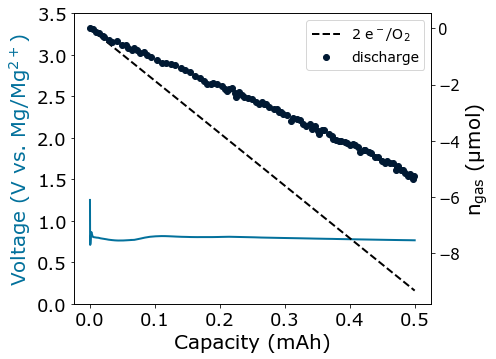

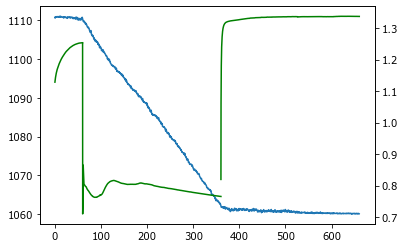

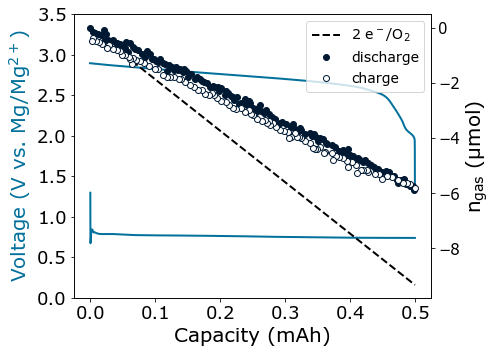

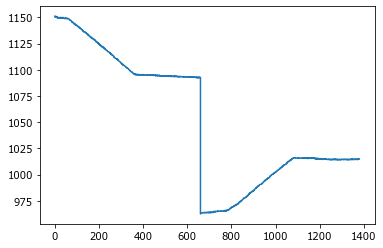

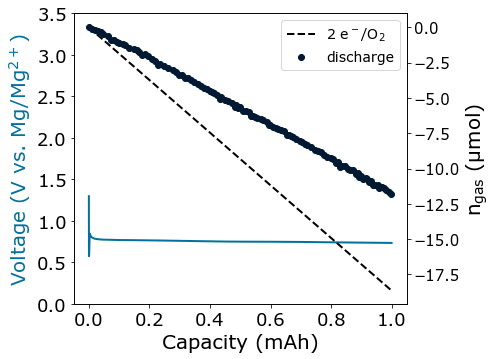

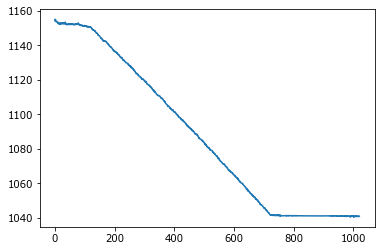

In [112]:

mgno3_ethanol = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210203_Mg(NO3)2_EtOH_100uA/210203_Mg(NO3)2_EtOH_discharge_O2_Ch3__2021-02-03_14.33_23.txt')
mgno3_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210203_Mg(NO3)2_EtOH_100uA/')
plot_cycle(mgno3_fold[1], mgno3_fold[1],mgno3_ethanol, 3)

plt.figure()
plt.plot(mgno3_ethanol['time/s']/60, mgno3_ethanol['pressure/torr'])
axv = plt.twinx()
axv.plot(mgno3_fold[0]['time/s']/60, mgno3_fold[0]['Ewe/V'], 'g')
axv.plot(mgno3_fold[1]['time/s']/60, mgno3_fold[1]['Ewe/V'], 'g')   
axv.plot(mgno3_fold[2]['time/s']/60, mgno3_fold[2]['Ewe/V'], 'g')

both_press = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210204_Mg(NO3)2_EtOH_cycle/210204_Mg(NO3)2_EtOH_100uA_Ch3_fullcycle.txt')
cycle_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210204_Mg(NO3)2_EtOH_cycle/')
cycle_fold[1]['time/s'] = cycle_fold[1]['time/s'] + 39600.10

plot_cycle(cycle_fold[4], cycle_fold[1],both_press, 3)
plt.figure()
plt.plot(both_press['time/s']/60, both_press['pressure/torr'])

disch_1mah = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210211_Mg(NO3)2_ETOH_discharge_1mAh/210211_Mg(NO3)2_ETOH_discharge_1mAh_Ch3__2021-02-11_12.06_22.txt')
disch_1mah_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210211_Mg(NO3)2_ETOH_discharge_1mAh/')
plot_cycle(disch_1mah_fold[1], disch_1mah_fold[1],disch_1mah, 3)
plt.figure()
plt.plot(disch_1mah['time/s']/60, disch_1mah['pressure/torr'])




titration_211_i = 0.85*.009876*10**3/2
titration_211_acid = 0.23*.0119*10**3/2


print(titration_211_i)
print(titration_211_acid)

NameError: name 'umoles' is not defined

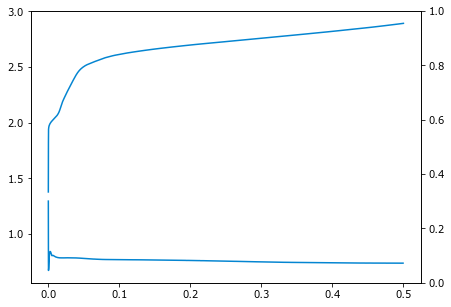

In [5]:

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
#ax.plot(ethanol_fold[0]['time/s'], ethanol_fold[0]['Ewe/V'], color = 'xkcd:cerulean')
ax.plot(cycle_fold[1]['Capacity/mA.h'], cycle_fold[1]['Ewe/V'], color ='xkcd:cerulean')
ax.plot(cycle_fold[4]['Capacity/mA.h'], cycle_fold[4]['Ewe/V'], color= 'xkcd:cerulean')

ax2.plot(both_press['time/s']/3600*0.1, umoles, 'o--', color = 'xkcd:tangerine')


ax2.set_ylabel('Moles of   Gas ($\mu$ mol)', size = 18, color = 'xkcd:tangerine')
ax.set_ylabel('Potential (V vs. Mg/Mg$^2+$)', size = 18, color = 'xkcd:cerulean')
ax.set_xlabel('Capacity (mAh)', size = 18)
ax.set_ylim(0,3.0)

In [ ]:
silver2p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210213_Ag-XC72_Mg(NO3)2_cycle_100uA_rpt/210213_Ag-XC72_Mg(NO3)2_cycle_100uA_fullp.txt')
silver2ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210213_Ag-XC72_Mg(NO3)2_cycle_100uA_rpt/')

plot_cycle(silver2ec[4], silver2ec[1], silver2p, 3)



In [ ]:
silver1p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210211_Ag-XC72_Mg(NO3)2_cycle_100uA/210211_Ag-XC72_Mg(NO3)2_cycle_100uA_Ch4__2021-02-11_12.34_51.txt')
silver1ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210211_Ag-XC72_Mg(NO3)2_cycle_100uA/')

plot_cycle(silver1ec[1], silver1ec[3], silver1p, 3)



In [ ]:
silver_separators_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210215_Ag-XC72-moreseparators_100uA_cycle/210215_Ag-XC72-moreseparators_100uA_cycle_Ch3__2021-02-15_17.59_29.txt')
silver_sep_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210215_Ag-XC72-moreseparators_100uA_cycle/')
plot_cycle(silver_sep_ec[1], silver_sep_ec[3], silver_separators_p, 3)




discharge current (mA): -0.49993125488636364
-2.678587469110243
o2 consumed: 15.502335435136459
o2 evolved: -15.243211659071193
-0.9832848555529282
e per mol on discharge = 2.4065499283490097
discharge current (mA): -0.09993591689411764
-310.5072413121006
o2 consumed: 0.1425754635944969
o2 evolved: -0.0354053362328699
-0.2483269935812186
e per mol on discharge = 5.692387257135526


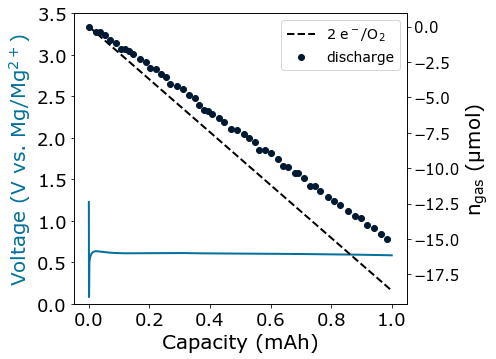

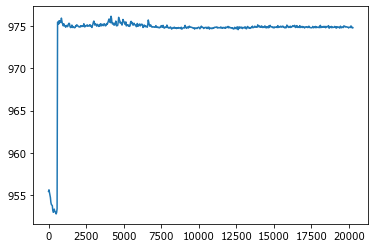

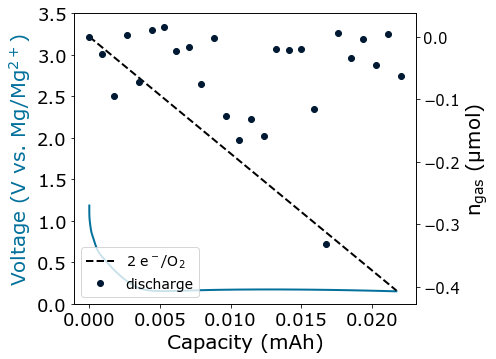

In [6]:
demsdisch= read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_1mAcurrent_dischargefordems/210217_Mg(NO3)2_1mAcurrent_dischargedems_Ch3__2021-02-17_13.42_28.txt')
demsdischfold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_1mAcurrent_dischargefordems/')
#plot_cycle(demsdischfold[1], demsdischfold[1], demsdisch, 3)



demsdisch['time/s']= demsdisch['time/s']-4565.78769083852-26

plot_cycle(demsdischfold[7], demsdischfold[7], demsdisch, 3)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210217_Mg(NO3)2_1mAcurrent_dischargefordems/210217_Mg(NO3)2_500uAcurrent_discharge.png', transparent = True, dpi=600, bbox_inches='tight')


arcontrol_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210218_Mg_control_dischargeunderAr/210218_Mg_control_dischargeunderAr_Ch3__2021-02-18_14.43_52.txt')
arcontrol_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210218_Mg_control_dischargeunderAr/')

plt.figure()
plt.plot(arcontrol_p['time/s'], arcontrol_p['pressure/torr'])

plot_cycle(arcontrol_fold[1], arcontrol_fold[1], arcontrol_p, 3)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210218_Mg_control_dischargeunderAr/210218_Mg_control_dischargeunderAr.png', transparent = True, dpi=600, bbox_inches='tight')


discharge current (mA): -0.049669274384615394
inf
o2 consumed: 0.0974305168700198
o2 evolved: 0.009561377620627809
0.09813534740232838
e per mol on discharge = 0.00014094440238678654


/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars


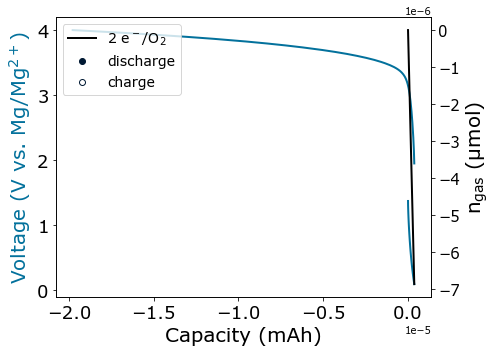

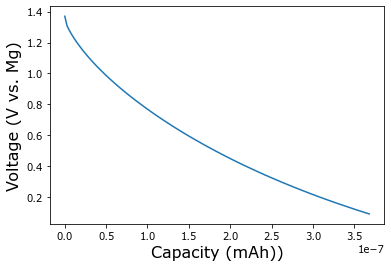

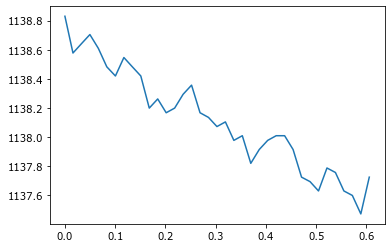

In [160]:
MgOtf_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210219_nonaqueousMg_MgOTf2_DME_cycle/210219_nonaqueousMg_MgOTf2_DME_cycle_50uA_Ch3__2021-02-19_16.57_31.txt')
MgOtf_f = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210219_nonaqueousMg_MgOTf2_DME_cycle/')

plot_cycle(MgOtf_f[6], MgOtf_f[8], MgOtf_p, 3)

plt.figure()
plt.plot(MgOtf_f[6]['Capacity/mA.h'], MgOtf_f[6]['Ewe/V'])
plt.ylabel('Voltage (V vs. Mg)', size=16)
plt.xlabel('Capacity (mAh))', size=16)

plt.figure()
plt.plot(MgOtf_p['time/s'][:-60]/3600, MgOtf_p['pressure/torr'][:-60])

discharge current (mA): -0.099861772672
-8.676242610339456
o2 consumed: 4.4892475470780795
o2 evolved: 2.0293914068136303
0.4520560262118987
e per mol on discharge = 2.1187226751339674
discharge current (mA): -0.09997764373907102
-4.3157013589531354
o2 consumed: 6.799707489395118
o2 evolved: -6.631589675797699
-0.9752757285722045
e per mol on discharge = 2.071539159966077
discharge current (mA): -0.0998105104
inf
o2 consumed: -20.550081103838153
o2 evolved: -20.550081103838153
1.0


/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kedzie/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars


e per mol on discharge = -0.00022265423287221695
discharge current (mA): -0.49979639519417474
-3.158187690898092
o2 consumed: 35.43932812088795
o2 evolved: -35.28043205848368
-0.9955163917932571
e per mol on discharge = 2.1050886278479264
discharge current (mA): -0.4998105653211889
-604.9624842582582
o2 consumed: 0.2993857853080897
o2 evolved: -0.29868675576287274
-0.9976651211262499
e per mol on discharge = 314.5316238112526


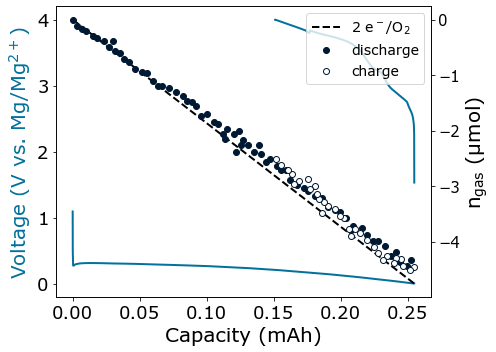

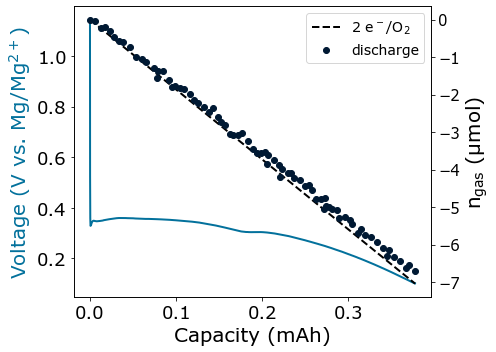

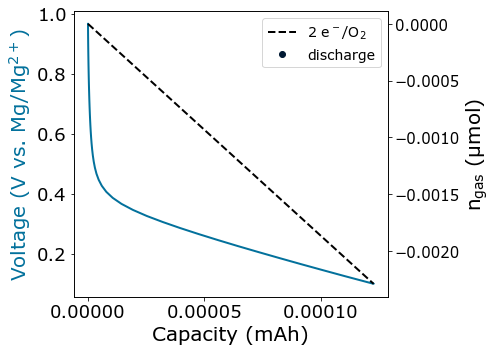

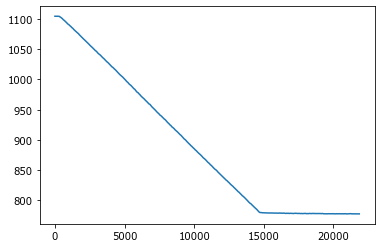

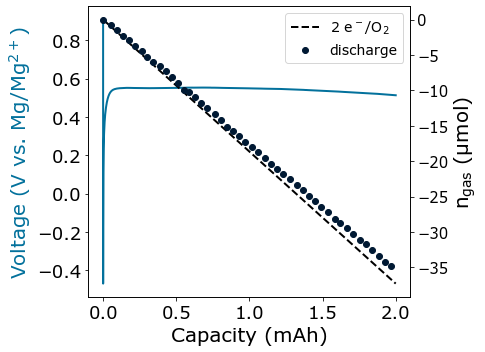

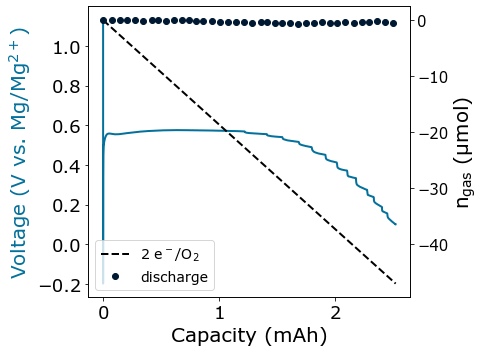

In [93]:
mgno32_dme_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210309_nonaqueous_Mg(NO3)2_DME/210309_nonaqueous_Mg(NO3)2_DME_Ch3__2021-03-09_12.36_14.txt')
mgno32_dme_f = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210309_nonaqueous_Mg(NO3)2_DME/')

plot_cycle(mgno32_dme_f[1], mgno32_dme_f[3], mgno32_dme_p, 3)


dmefordems_f = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210311_MgO2_cycle100uA_nonaqueousDME_dems/')
dmefordems_p= read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210311_MgO2_cycle100uA_nonaqueousDME_dems/210311_MgO2_discharge100uA_nonaqueousDME_Ch3__2021-03-11_14.20_16.txt')

plot_cycle(dmefordems_f[1], dmefordems_f[1], dmefordems_p, 3)


dmso = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg(NO3)2_DMSO_cycle_nonaqueous/')
dmso_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg(NO3)2_DMSO_cycle_nonaqueous/210318_Mg(NO3)2_DMSO_cycle_nonaqueous_2_Ch4__2021-03-18_16.06_24.txt')
plot_cycle(dmso[1], dmso[1],  dmso_p, 3)

xrd_argon = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg(NO3)2_EtOH_XRDsample_Argon/')
xrd_argon_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg(NO3)2_EtOH_XRDsample_Argon/210318_Mg(NO3)2_EtOH_XRDsample3_Ch4__2021-03-18_21.03_49.txt')

plt.figure()
plt.plot(xrd_argon_p['time/s'], xrd_argon_p['pressure/torr'])
plot_cycle(xrd_argon[4], xrd_argon[4],  xrd_argon_p, 4)


xrd_air = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg_EtOH_XRDsample_air/')
xrd_air_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210318_Mg_EtOH_XRDsample_air/210318_Mg_EtOH_XRDsample_air3_Ch3__2021-03-18_21.10_16.txt')

plot_cycle(xrd_air[4], xrd_air[4],  xrd_air_p, 4)



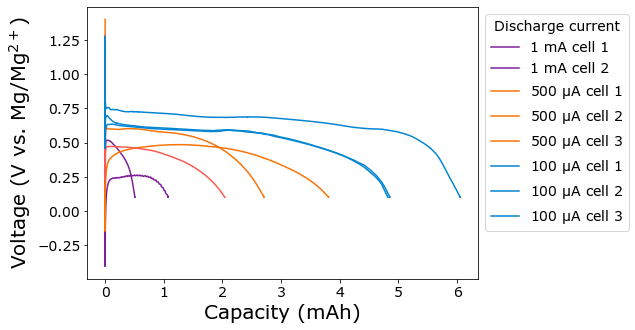

In [3]:
# GRAVIMETRIC CAPACITY STUDY

discharge1mA = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210311_gravimetricstudy_longdischarge_1mA/')
discharge500uA = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210309_Mg(NO3)2_EtOH_gravimetricstudy_discharge_500uA/')
discharge100uA = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_gravimetric_longdischarge_100uA/')
discharge500uA2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210317_gravimetric_longdischarge_500uA/')
discharge500uA_3 =folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210408_gravimetric_longdischarge_500uA/')

discharge1mA_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210401_gravimetric_longdischarge_1mA/')
discharge100uA_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210409_Mg_gravimetric_longdischarge_100uA/')
discharge500uA_4 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210423_Mg_longdischarge_500uA/')
discharge100uA_3 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210426_Mg_longdischarge_100uA/')
discharge1mA_3 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210511_Mg_longdischarge_1mA/')



fig, ax= plt.subplots( figsize=(7,5))

#ax.plot(discharge1mA[1]['Capacity/mA.h'], discharge1mA[1]['Ewe/V'], label = '1mA')

ax.plot(discharge1mA_2[1]['Capacity/mA.h'], discharge1mA_2[1]['Ewe/V'], label = '1 mA cell 1', color = 'xkcd:purple')
ax.plot(discharge1mA_3[1]['Capacity/mA.h'], discharge1mA_3[1]['Ewe/V'], label = '1 mA cell 2', color = 'xkcd:purple')


ax.plot(discharge500uA2[1]['Capacity/mA.h'], discharge500uA2[1]['Ewe/V'], label = '500 $\mu$A cell 1', color = 'xkcd:orange')
ax.plot(discharge500uA_3[1]['Capacity/mA.h'], discharge500uA_3[1]['Ewe/V'], label = '500 $\mu$A cell 2', color = 'xkcd:orange')
ax.plot(discharge500uA_4[1]['Capacity/mA.h'][:10], discharge500uA_4[1]['Ewe/V'][:10],label = '500 $\mu$A cell 3', color = 'xkcd:orange')
ax.plot(discharge500uA_4[4]['Capacity/mA.h'][20:], discharge500uA_4[4]['Ewe/V'][20:], label = '', color= 'xkcd:coral')




ax.plot(discharge100uA[1]['Capacity/mA.h'], discharge100uA[1]['Ewe/V'], label = '100 $\mu$A cell 1', color = 'xkcd:cerulean')
ax.plot(discharge100uA_2[1]['Capacity/mA.h'], discharge100uA_2[1]['Ewe/V'], label = '100 $\mu$A cell 2', color = 'xkcd:cerulean')
ax.plot(discharge100uA_3[1]['Capacity/mA.h'], discharge100uA_3[1]['Ewe/V'], label = '100 $\mu$A cell 3', color = 'xkcd:cerulean')


ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize=20)
ax.set_xlabel('Capacity (mAh)', fontsize=20)
leg = ax.legend(fontsize=14, bbox_to_anchor=(1,1))
leg.set_title('Discharge current',prop={'size':14})
ax.tick_params(axis='both', which='major', labelsize=14)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_gravimetric_longdischarge_100uA/210310_overalllongdischargestudy.png', transparent = True, dpi=600, bbox_inches='tight')

#print(discharge100uA[1]['Capacity/mA.h'].iloc[-1])

-0.7473714599556783
exchange current density: -2.4067328428682258
beta: 0.03850132270474012


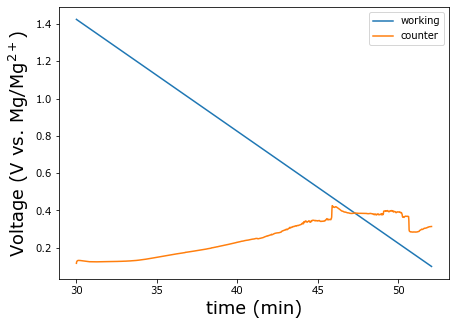

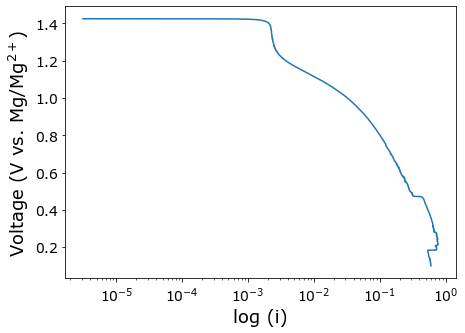

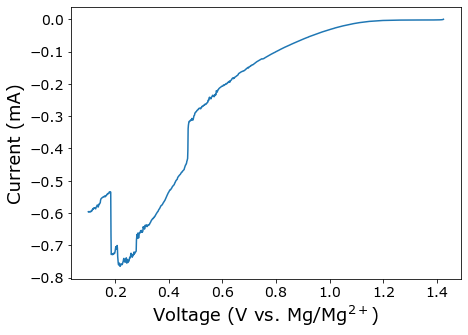

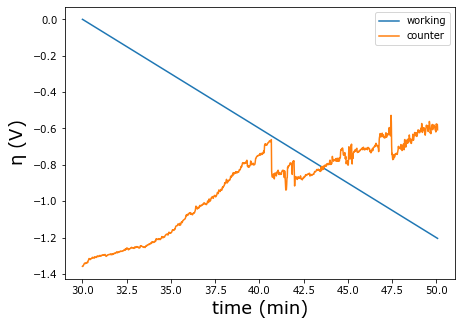

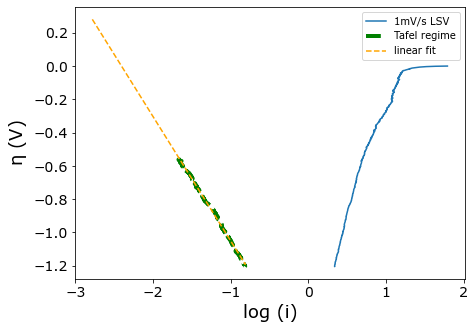

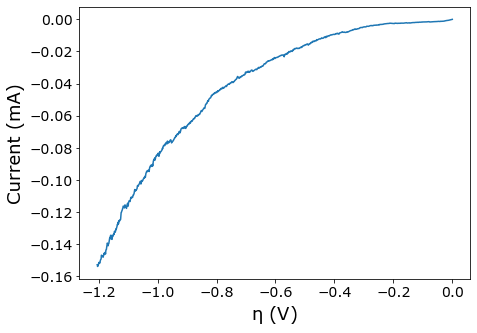

In [203]:
LSV = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_LSV_1mVs_3electrode_Mg_EtOH/')

fig,axe = plt.subplots( figsize=(7,5))
axe.plot(LSV[1]['time/s']/60, LSV[1]['Ewe/V'], label = 'working' )
axe.plot(LSV[1]['time/s']/60, LSV[1]['<Ece>/V'], label= 'counter')
axe.set_xlabel('time (min)', fontsize=18)
axe.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize=18)
axe.legend()

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_LSV_1mVs_3electrode_Mg_EtOH/210310_working_counter_voltages.png', transparent = True, dpi=600, bbox_inches='tight')



fig, ax= plt.subplots( figsize=(7,5))
ax.plot(  abs(LSV[1]['<I>/mA'][0:]), LSV[1]['Ewe/V'][0:], label = '1mV/s')
ax.set_xlabel('log (i)', fontsize=18)
ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize=18)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_LSV_1mVs_3electrode_Mg_EtOH/210310_LSV_Tafelplot.png', transparent = True, dpi=600, bbox_inches='tight')



fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot( LSV[1]['Ewe/V'], LSV[1]['<I>/mA'])
ax2.set_xlabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize=18)
ax2.set_ylabel('Current (mA)', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_LSV_1mVs_3electrode_Mg_EtOH/210310_voltage_current_regular.png', transparent = True, dpi=600, bbox_inches='tight')


LSV2= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210320_LSV_1mVs_3electrode_Mg_EtOH_repeat/')
ocv= LSV2[1]['Ewe/V'].iloc[0]

fig,ax3 = plt.subplots( figsize=(7,5))
ax3.plot(LSV2[1]['time/s']/60, LSV2[1]['Ewe/V'] - ocv , label = 'working' )
ax3.plot(LSV2[1]['time/s']/60, LSV2[1]['<Ece>/V']-ocv, label= 'counter')
ax3.set_xlabel('time (min)', fontsize=18)
ax3.set_ylabel('$\eta$ (V)', fontsize=18)
ax3.legend()

fig, ax= plt.subplots( figsize=(7,5))
ax.plot(  np.log10(abs(LSV2[1]['<I>/mA'][0:]))/-2.4067328428682258, LSV2[1]['Ewe/V'][0:]-ocv, label = '1mV/s LSV')
ax.set_xlabel('log (i)', fontsize=18)
ax.set_ylabel('$\eta$ (V)', fontsize=18)
#ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=14)

ax.plot(np.log10(abs(LSV2[1]['<I>/mA'][560:])), LSV2[1]['Ewe/V'][560:]-ocv, 'g--', linewidth=4 , label = 'Tafel regime')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210310_LSV_1mVs_3electrode_Mg_EtOH/210310_LSV_Tafelplot.png', transparent = True, dpi=600, bbox_inches='tight')


fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot( LSV2[1]['Ewe/V']-ocv, LSV2[1]['<I>/mA'])
ax2.set_xlabel('$\eta$ (V)', fontsize=18)
ax2.set_ylabel('Current (mA)', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)


x = np.array(np.log10(abs(LSV2[1]['<I>/mA']))[560:])
y = np.array((LSV2[1]['Ewe/V'][560:]- ocv))
m, b = np.polyfit(x, y, 1)
print(m)
newx= np.array(np.log10(abs(LSV2[1]['<I>/mA'])))
ax.plot(newx[100:], m*newx[100:]+b, '--', color='orange', label = 'linear fit' )
ax.legend()
io = -b/m
print('exchange current density: '+ str(io))
beta = (-2.303 *8.314*290/(m *2 * 96485)) #/np.log10(abs(io))

print('beta: ' + str(beta))

1.1591955800327234 -0.00999711265841573
1.0378002728915663 -0.049995500356481475
0.9571428792352942 -0.09999368035652174
0.8479837598888887 -0.24998255941666667
0.7422035899999999 -0.4999391336301369
0.663442146607143 -0.99992618546875


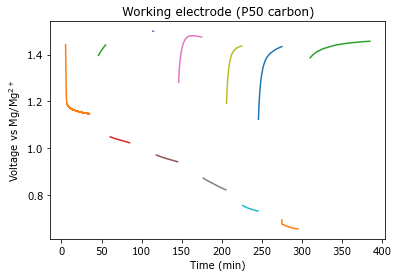

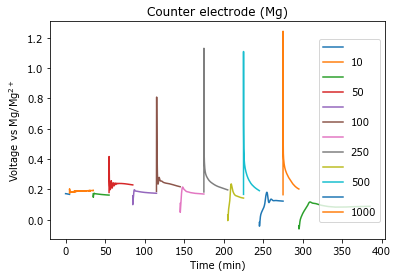

In [71]:
#lsv from 4

repeat_cc_lsv = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210403_constantcurrent_3electrode_Mg_o2/')

plt.figure()
for i in range(len(repeat_cc_lsv)):
    plt.plot(repeat_cc_lsv[i]['time/s'][70:]/60,repeat_cc_lsv[i]['Ewe/V'][70:])
plt.xlabel('Time (min)')
plt.ylabel('Voltage vs Mg/Mg$^{2+}$')
plt.title('Working electrode (P50 carbon)')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210403_constantcurrent_3electrode_Mg_o2/210403_3electrode_WE.png', transparent = True, dpi=600, bbox_inches='tight')


    
plt.figure()
for i in range(len(repeat_cc_lsv)):
    plt.plot(repeat_cc_lsv[i]['time/s']/60,repeat_cc_lsv[i]['Ece/V'])
plt.xlabel('Time (min)')
plt.ylabel('Voltage vs Mg/Mg$^{2+}$')
plt.title('Counter electrode (Mg)')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210403_constantcurrent_3electrode_Mg_o2/210403_3electrode_counterE.png', transparent = True, dpi=600, bbox_inches='tight')

plt.legend(['', '10', '', '50', '', '100', '', '250', '', '500', '', '1000'], loc='center right')

v_10 = np.mean(repeat_cc_lsv[1]['Ewe/V'][1500:])
print(v_10, np.mean(repeat_cc_lsv[1]['I/mA']))

v_50 = np.mean(repeat_cc_lsv[3]['Ewe/V'][50:])
print(v_50, np.mean(repeat_cc_lsv[3]['I/mA']))

v_100 = np.mean(repeat_cc_lsv[5]['Ewe/V'][60:])
print(v_100, np.mean(repeat_cc_lsv[5]['I/mA']))

v_250 = np.mean(repeat_cc_lsv[7]['Ewe/V'][60:])
print(v_250, np.mean(repeat_cc_lsv[7]['I/mA']))

v_500 = np.mean(repeat_cc_lsv[9]['Ewe/V'][70:])
print(v_500, np.mean(repeat_cc_lsv[9]['I/mA']))

v_1000 = np.mean(repeat_cc_lsv[11]['Ewe/V'][80:])
print(v_1000, np.mean(repeat_cc_lsv[11]['I/mA']))

[-1e-05, -5e-05, -0.0001, -0.00025, -0.0005, -0.001]
1476.8865
[-5.         -4.30103    -4.         -3.60205999 -3.30103    -3.        ]


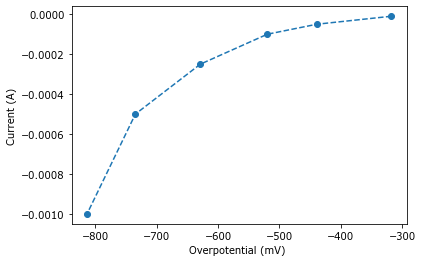

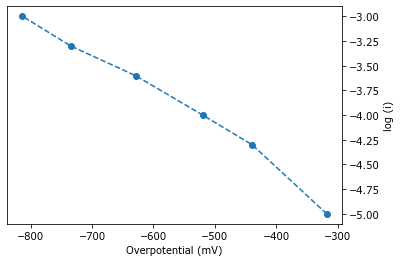

In [91]:
tafel_i = [-10, -50, -100, -250, -500, -1000]
tafel_i = [i / 1000000 for i in tafel_i] #now in units of Amps

tafel_v = [1.1591955800327234, 1.0378002728915663, 0.9571428792352942, 0.8479837598888887, 0.7422035899999999,0.663442146607143]
tafel_v = [v * 1000 for v in tafel_v] # in units of mV
print(tafel_i)

ocv = repeat_cc_lsv[0]['Ewe/V'].iloc[-1]*1000 #ocv in units of mV
print(ocv)

tafel_v = tafel_v - ocv


plt.figure()
plt.plot( tafel_v, tafel_i, 'o--')
plt.xlabel('Overpotential (mV) ')
plt.ylabel('Current (A)')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210403_constantcurrent_3electrode_Mg_o2/210403_tafel_linear.png', transparent = True, dpi=600, bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot( tafel_v, np.log10(np.abs(tafel_i)),  'o--')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel('log (i)')#' ($\mu$A) ')
ax.set_xlabel('Overpotential (mV)')

print(np.log10(np.abs(tafel_i)))

discharge current (mA): -0.49998527164473683
-5.990057656167079
o2 consumed: 0.9630292109057308
o2 evolved: -0.85445113508014
-0.8872536008295399
e per mol on discharge = 2.039221347201912
discharge current (mA): -0.5000009760526316
-6.595996587895346
o2 consumed: 15.433076001121023
o2 evolved: 21.284598877689078
1.3791546724802635
e per mol on discharge = 2.417718929263426
discharge current (mA): -0.5000165727405859
-23.169623271298168
o2 consumed: 17.899453831906
o2 evolved: 22.128286913426876
1.2362548668374969
e per mol on discharge = 2.084649797354967


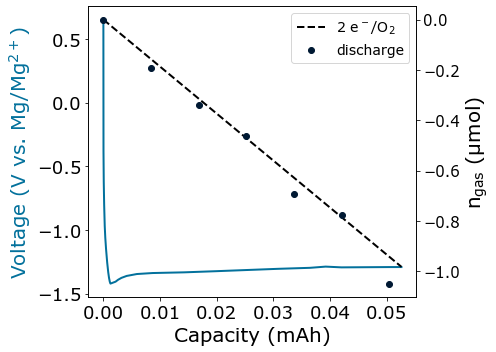

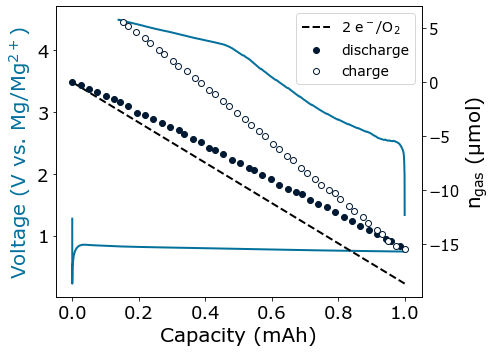

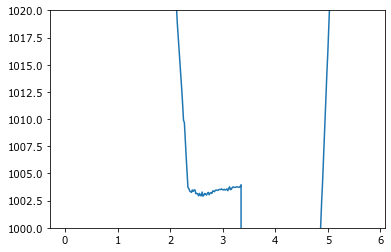

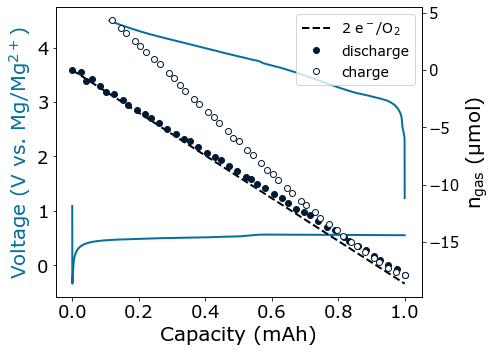

In [95]:
dmsotest_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210404_Mg_DMSO_nonaqueous_repeat/210404_Mg_DMSO_nonaqueous_repeat_Ch4__2021-04-04_16.06_27.txt')
dmsotest = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210404_Mg_DMSO_nonaqueous_repeat/')

plot_cycle(dmsotest[1], dmsotest[1], dmsotest_p, 4)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210404_Mg_DMSO_nonaqueous_repeat/210404_DMSO_discharge.png', transparent = True, dpi=600, bbox_inches='tight')

xc72test_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210408_Mg_EtOH_XC72_glovebox/210408_Mg_EtOH_XC72_glovebox_Ch4__2021-04-08_11.14_59.txt')
xc72test = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210408_Mg_EtOH_XC72_glovebox/')

plot_cycle(xc72test[1], xc72test[3], xc72test_p, 4)

plt.figure()
plt.plot(xc72test_p['time/s']/3600, xc72test_p['pressure/torr'] )
plt.ylim(1000,1020)


acidpretreat_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210404_Mg_acidtreatment_EtOH_disch/210404_Mg_acidtreatment_EtOH_disch_Ch4__2021-04-04_17.19_31.txt')
acidpretreat = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210404_Mg_acidtreatment_EtOH_disch/')
plot_cycle(acidpretreat[1], acidpretreat[3], acidpretreat_p, 4)




discharge current (mA): -0.24998231014784947
-2.8079840942617165
o2 consumed: 36.35498863302551
o2 evolved: -35.99077938658871
-0.9899818632839306
e per mol on discharge = 2.0524890867892363
discharge current (mA): -0.2500147042457737
-3.1819582201397516
o2 consumed: 32.245807929176564
o2 evolved: -32.171503070537014
-0.997695673843783
e per mol on discharge = 2.3143409942159994
discharge current (mA): -0.9999018289
-2.4704564058599483
o2 consumed: 30.848116972762767
o2 evolved: -30.309296943736072
-0.9825331306444914
e per mol on discharge = 2.418855906017207
discharge current (mA): -0.49995748174563587
195.63344751673426
o2 consumed: -0.8435948202166514
o2 evolved: 1.179917686752816
-1.3986782024690365
e per mol on discharge = -132.67776574001306


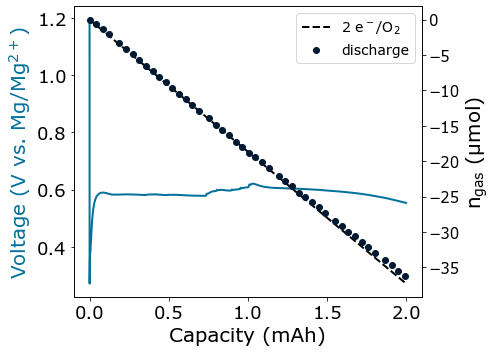

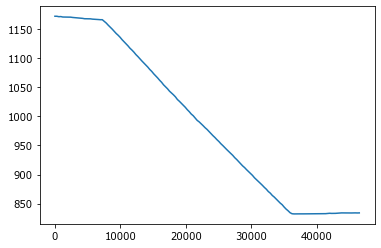

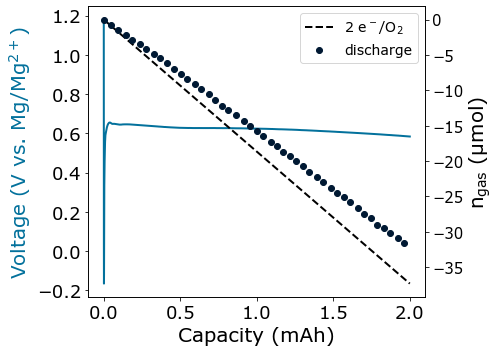

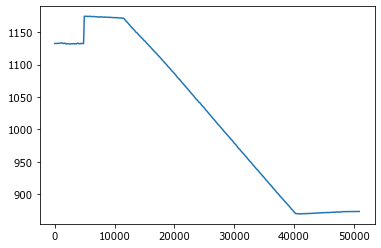

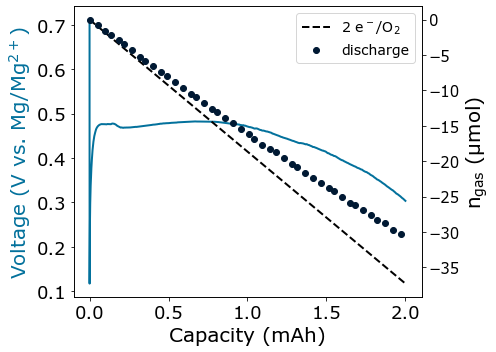

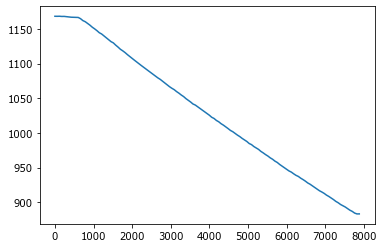

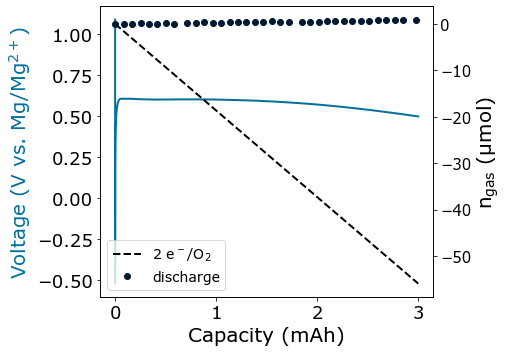

In [59]:
sem_air_250_1_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210419_Mg_air_disch_250uA_SEMsample/210419_Mg_air_disch_250uA_SEMsample_Ch3__2021-04-19_18.13_15.txt')
sem_air_250_1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210419_Mg_air_disch_250uA_SEMsample/')

plot_cycle(sem_air_250_1[1], sem_air_250_1[1], sem_air_250_1_p, 3)

plt.figure()
plt.plot(sem_air_250_1_p['time/s'], sem_air_250_1_p['pressure/torr'])


sem_Ar_250_1_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210419_Mg_glovebox_disch_250uA_SEMsample/210419_Mg_glovebox_disch_250uA_SEMsample_Ch4__2021-04-19_16.51_17.txt')
sem_Ar_250_1 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210419_Mg_glovebox_disch_250uA_SEMsample/')

plot_cycle(sem_Ar_250_1[1], sem_Ar_250_1[1], sem_Ar_250_1_p, 4)

plt.figure()
plt.plot(sem_Ar_250_1_p['time/s'], sem_Ar_250_1_p['pressure/torr'])

sem_Ar_1mA_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210420_Mg_glovebox_disch_1mA_SEMsample/210420_Mg_glovebox_disch_1mA_SEMsample_Ch4__2021-04-20_10.36_01.txt')
sem_Ar_1mA = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210420_Mg_glovebox_disch_1mA_SEMsample/')

plot_cycle(sem_Ar_1mA[1], sem_Ar_1mA[1], sem_Ar_1mA_p, 4)


plt.figure()
plt.plot(sem_Ar_1mA_p['time/s'], sem_Ar_1mA_p['pressure/torr'])


sem_air_2_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210426_Mg_glovebox_500uA_SEMsample/210426_Mg_glovebox_500uA_SEMsample_Ch3__2021-04-26_16.39_24.txt')
sem_air_2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210426_Mg_glovebox_500uA_SEMsample/')

plot_cycle(sem_air_2[1], sem_air_2[1], sem_air_2_p, 3)



26.42


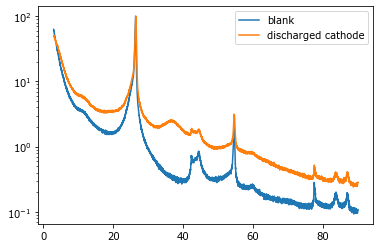

In [62]:
p50xrd = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/XRD/Carbon_Electrode.csv', header=0, names=['theta','signal'])
discharged = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/XRD/210504_Dischargedcell_3mAh_xrd.csv', header=0, names=['theta','signal'])
weekrest = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/XRD/MgO2_MgO_Carbon Electrode.csv', header=1, names=['theta','signal', 'theta2', 'signal2'])



max_index_blank = p50xrd['signal'].idxmax()
max_index_disch = discharged['signal'].idxmax()
max_index_week1 = weekrest['signal'].idxmax()
max_index_week2 = weekrest['signal2'].idxmax()
print(p50xrd['theta'].iloc[max_index_blank])
p50xrd['signal']=p50xrd['signal']/p50xrd['signal'].iloc[max_index_blank]*100
discharged['signal']=discharged['signal']/discharged['signal'].iloc[max_index_disch]*100
weekrest['signal']=weekrest['signal']/weekrest['signal'].iloc[max_index_week1]*100
weekrest['signal2']=weekrest['signal2']/weekrest['signal2'].iloc[max_index_week2]*100




plt.figure()
plt.semilogy(p50xrd['theta'],p50xrd['signal'], label = 'blank' )
#plt.semilogy(discharged['theta'],discharged['signal'], label = 'discharged cathode' )
plt.semilogy(weekrest['theta'],weekrest['signal'], label = 'discharged cathode' )
#plt.semilogy(weekrest['theta2'],weekrest['signal2'], label = 'week rest side 2' )



#plt.ylim([0,10])
plt.xlim()
plt.legend()

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/XRD/MgO2_P50cathode_xrd_2.png', transparent = True, dpi=600, bbox_inches='tight')


#2.3 angstrom bond

discharge current (mA): -0.5000948284715026
-8799.862113312034
o2 consumed: 0.10462482562073205
o2 evolved: -0.2769438764804164
-2.647018762873219
e per mol on discharge = 1070.0916510590828


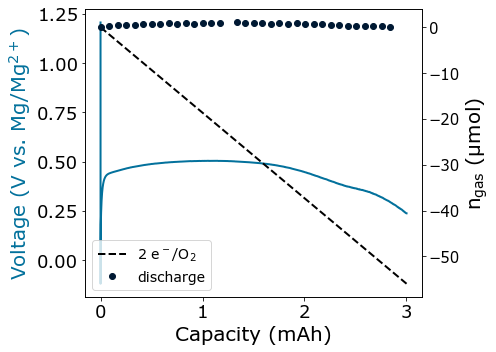

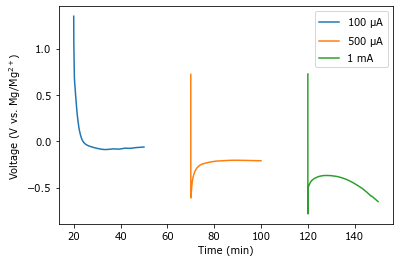

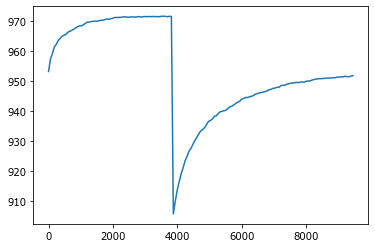

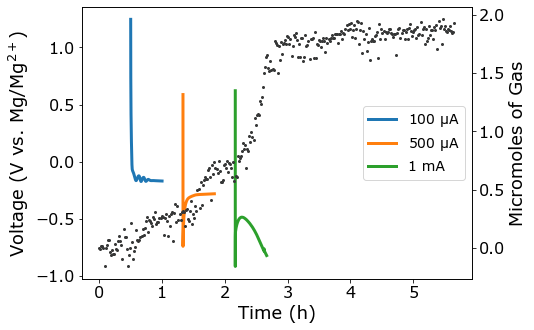

In [8]:
xrd_disch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210504_XRDsample_Mg_disch_500uA_rpt/210504_XRDsample_Mg_disch_500uA_rpt_Ch4__2021-05-04_09.42_07.txt')
xrd_disch = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210504_XRDsample_Mg_disch_500uA_rpt/')
plot_cycle(xrd_disch[1], xrd_disch[1], xrd_disch_p, 4)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210504_XRDsample_Mg_disch_500uA_rpt/210504_XRDsample_500uA.png', transparent = True, dpi=600, bbox_inches='tight')

solventstability_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Arcontrol_Mg_EtOH_stabilitywindow/210528_Arcontrol_Mg_EtOH_stabilitywindow_Ch3__2021-05-28_10.46_32.txt')
solventstability = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Arcontrol_Mg_EtOH_stabilitywindow/')

plt.figure()
currents = ['0','100 $\mu$A','0', '500 $\mu$A','0', '1 mA']
for i in range(len(solventstability)):
    if i%2 != 0:
        plt.plot(solventstability[i]['time/s']/60, solventstability[i]['Ewe/V'], label = str(currents[i]) )
#     else:
#         plt.plot(solventstability[i]['time/s'], solventstability[i]['Ewe/V'], color = 'teal')
plt.xlabel('Time (min)')
plt.ylabel('Voltage (V vs. Mg/Mg$^{2+}$)')
plt.legend()
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210528_Arcontrol_Mg_EtOH_stabilitywindow/210528_Arcontrol_Mg_EtOH_stabilitywindow.png', transparent = True, dpi=600, bbox_inches='tight')

plt.figure()
plt.plot(solventstability_p['time/s'], solventstability_p['pressure/torr'])

solventstability2p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210609_Arcontrol_Mg_EtOH_stability_rpt/210609_Arcontrol_Mg_EtOH_stability_rpt_Ch4__2021-06-09_14.58_26.txt')
solventstability2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210609_Arcontrol_Mg_EtOH_stability_rpt/')

umoles = solventstability2p['pressure/torr']/760*headspace(4)/(solventstability2p['temperature/C']+273)/0.082057
umoles = umoles - umoles.iloc[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()

ax2.plot(solventstability2p['time/s']/60/60,umoles, 'o', color = 'xkcd:dark grey', markersize= 2 )


currents = ['0','100 $\mu$A','0', '500 $\mu$A','0', '1 mA']
for i in range(len(solventstability2)):
    if i%2 != 0:
        ax.plot(solventstability2[i]['time/s']/60/60, solventstability2[i]['Ewe/V'], label = str(currents[i]), linewidth = 3 )
#     else:
#         plt.plot(solventstability[i]['time/s'], solventstability[i]['Ewe/V'], color = 'teal')


ax2.set_ylabel('Micromoles of Gas', fontsize = 18)
ax.set_xlabel('Time (h)', fontsize = 18)
ax.set_ylabel('Voltage (V vs. Mg/Mg$^{2+}$)', fontsize = 18)
ax.legend(loc = 'center right', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='y', which='major', labelsize=16)
    
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210609_Arcontrol_Mg_EtOH_stability_rpt/210609_Mg_solventstability_rpt.png', transparent = True, dpi=600, bbox_inches='tight')



In [1]:
#Zn-O2 battery trial
xrd_disch_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210504_XRDsample_Mg_disch_500uA_rpt/210504_XRDsample_Mg_disch_500uA_rpt_Ch4__2021-05-04_09.42_07.txt')
xrd_disch = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210504_XRDsample_Mg_disch_500uA_rpt/')
plot_cycle(xrd_disch[1], xrd_disch[1], xrd_disch_p, 4)





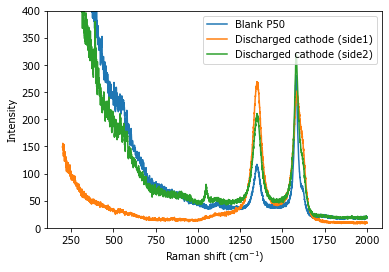

In [42]:

#RAMAN

backgroundsig= pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/Raman/20210617_Mg-O2_RAMAN/Detector_Dark_Measurement.txt',  sep='\t', names =['shift','intensity'])

p50blank = pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/Raman/20210617_Mg-O2_RAMAN/CarbonPaper_532nm_ND1_Hole150um_1800grmm_100X_10s_10acc.txt', sep='\t', names =['shift','intensity'])
dischargedside1 =  pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/Raman/20210617_Mg-O2_RAMAN/Discharged_Cathode_532nm_ND1_Hole150um_1800grmm_100X_10S_10acc.txt', sep='\t', names =['shift','intensity'])
dischargedside2 =  pd.read_csv('/Users/kedzie/Documents/Berkeley/Research/Data/Raman/20210617_Mg-O2_RAMAN/Discharged_Cathode_White_Side_532nm_ND1_Hole150um_1800grmm_100X_10S_10acc.txt', sep='\t', names =['shift','intensity'])
p50blank['intensity'] = p50blank['intensity'] - backgroundsig['intensity']
dischargedside1['intensity'] = dischargedside1['intensity'] - backgroundsig['intensity']
dischargedside2['intensity'] = dischargedside2['intensity'] - backgroundsig['intensity']




plt.figure()
#plt.plot(backgroundsig['shift'], backgroundsig['intensity'], label='background signal')
plt.plot(p50blank['shift'], p50blank['intensity'], label='Blank P50')
plt.plot(dischargedside1['shift'], dischargedside1['intensity'], label='Discharged cathode (side1)')
plt.plot(dischargedside2['shift'], dischargedside2['intensity'], label='Discharged cathode (side2)')

plt.xlabel('Raman shift (cm$^{-1}$)')
plt.ylabel('Intensity')
plt.legend()
plt.ylim(0,400)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/Raman/20210617_Mg-O2_RAMAN/discharged_Mgcathode_RAMAN_zoomed.png', transparent = True, dpi=600, bbox_inches='tight')



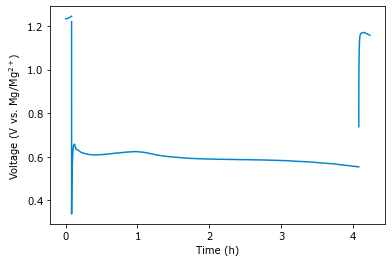

In [41]:
ramandisch = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210617_Mg_RAMAN_500uAdisch_2mAh/')
plt.figure()
plt.plot(ramandisch[0]['time/s']/3600, ramandisch[0]['Ewe/V'], color = 'xkcd:cerulean')
plt.plot(ramandisch[1]['time/s']/3600, ramandisch[1]['Ewe/V'], color = 'xkcd:cerulean')
plt.plot(ramandisch[2]['time/s']/3600, ramandisch[2]['Ewe/V'], color = 'xkcd:cerulean')
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V vs. Mg/Mg$^{2+}$)')

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210617_Mg_RAMAN_500uAdisch_2mAh/210617_Mg_RAMAN_500uAdisch_2mAh.png', transparent = True, dpi=600, bbox_inches='tight')







discharge current (mA): -0.09999770013005463
-3.8200899943189834
o2 consumed: 12.668400695418043
o2 evolved: -12.686810432908416
-1.001453201389267
e per mol on discharge = 2.9451803482502936


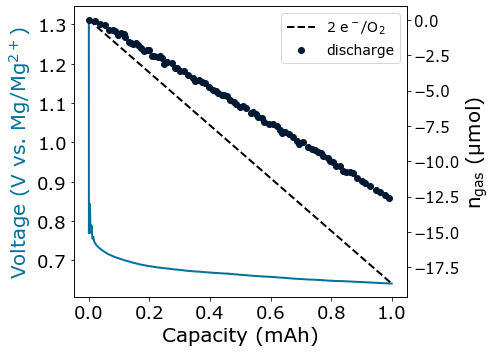

In [43]:
graphite_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210624_Mg_O2_graphitecathode_disch_100uA/210624_Mg_O2_graphitecathode_disch_100uA_Ch4__2021-06-24_13.56_03.txt')
graphitemg = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210624_Mg_O2_graphitecathode_disch_100uA/')
plot_cycle(graphitemg[1], graphitemg[1], graphite_p, 4)




discharge current (mA): -0.5000323189125295
-3.8218842193437847
o2 consumed: 14.129013406169918
o2 evolved: -13.925816076557894
-0.9856184346514039
e per mol on discharge = 2.6410193077509927
discharge current (mA): -0.5000602926801803
-6.512823620148697
o2 consumed: 12.058478494977265
o2 evolved: -11.903829527930242
-0.9871750845588488
e per mol on discharge = 3.0946638076625828
discharge current (mA): -0.500089278449074
-2.863422982611756
o2 consumed: 14.17113842828121
o2 evolved: -13.931595836481563
-0.9830964468372142
e per mol on discharge = 2.6334730858095057


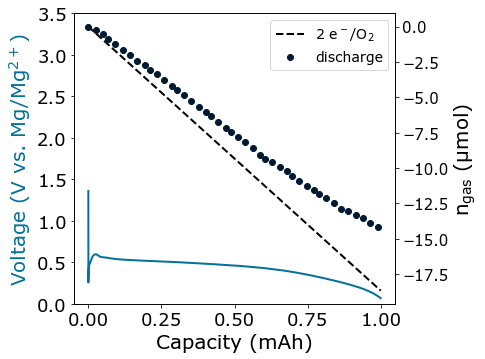

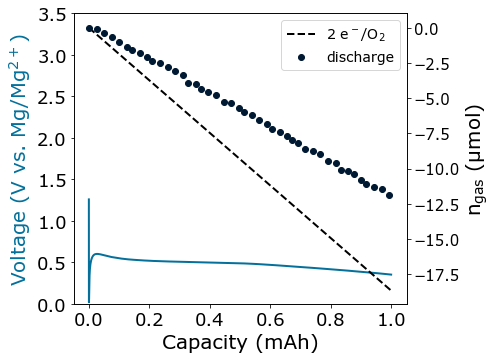

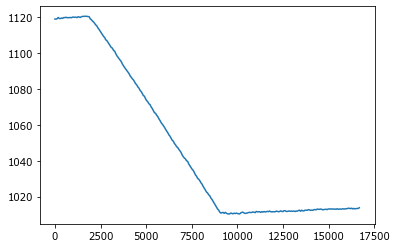

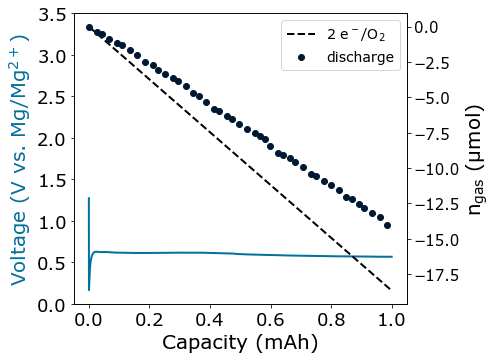

In [6]:
graphite_500p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210720_Mg_graphitecathode_disch_500uA/210720_Mg_graphitecathode_disch_500uA_Ch3__2021-07-20_09.43_33.txt')
graphite_500 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210720_Mg_graphitecathode_disch_500uA/')

plot_cycle(graphite_500[1], graphite_500[1], graphite_500p, 4)


graphite_ar_p = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210728_Mg_O2_graphite_noH2O_glovebox_500uA/210728_Mg_O2_graphite_noH2O_glovebox_500uA_Ch4__2021-07-28_09.49_45.txt')
graphite_ar_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210728_Mg_O2_graphite_noH2O_glovebox_500uA/')

plot_cycle(graphite_ar_ec[1], graphite_ar_ec[1], graphite_ar_p, 4)


plt.figure()
plt.plot(graphite_ar_p['time/s'], graphite_ar_p['pressure/torr'])


tims_disch = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210729_Mg_O2_P50_1mAh_sampleforTIMS/210729_Mg_O2_P50_1mAh_sampleforTIMS_Ch4__2021-07-29_14.49_35.txt')
tims_disch_ec = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210729_Mg_O2_P50_1mAh_sampleforTIMS/')
plot_cycle(tims_disch_ec[1], tims_disch_ec[1], tims_disch, 4)



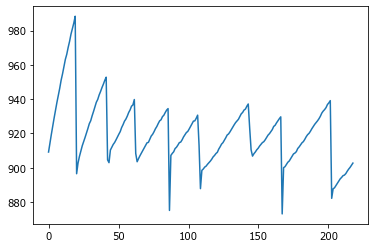

In [11]:
no3_otf_h2op = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210805_Mg_O2_MgOTf_NaNO3_H2O_elyte_disch/210805_Mg_O2_MgOTf_NaNO3_H2O_elyte_disch_Ch3__2021-08-05_14.26_19.txt')

plt.plot(no3_otf_h2op['time/s']/60, no3_otf_h2op['pressure/torr'])

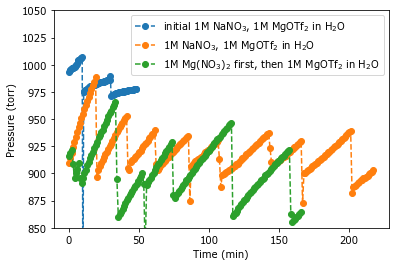

In [110]:
no3_otf_h2op = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210805_Mg_O2_MgOTf_NaNO3_H2O_elyte_disch/210805_Mg_O2_MgOTf_NaNO3_H2O_elyte_disch_Ch3__2021-08-05_14.26_19.txt')
jan_no3_otf_h2op = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210112_Mg_Ar_h2evolution_NO3_OTf/210112_Mg_Ar_h2evolution_NO3_OTf_Ch3__2021-01-12_14.51_15.txt')
staggered_no3_otf = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210816_MgOTf_MgNO3_H2O_staggered_disch/210816_MgOTf_MgNO3_H2O_staggered_disch_Ch3__2021-08-16_14.55_29.txt')

plt.figure()
plt.plot(jan_no3_otf_h2op['time/s']/60, jan_no3_otf_h2op['pressure/torr'], 'o--', label = 'initial 1M NaNO$_3$, 1M MgOTf$_2$ in H$_2$O')
plt.plot(no3_otf_h2op['time/s']/60, no3_otf_h2op['pressure/torr'], 'o--', label = '1M NaNO$_3$, 1M MgOTf$_2$ in H$_2$O')
plt.plot(staggered_no3_otf['time/s']/60, staggered_no3_otf['pressure/torr'], 'o--', label = '1M Mg(NO$_3$)$_2$ first, then 1M MgOTf$_2$ in H$_2$O')

plt.ylim(850,1050)
plt.ylabel( 'Pressure (torr)')
plt.xlabel('Time (min)')
plt.legend()